In [1]:
import os  # Provides a way of using operating system dependent functionality like reading or writing to the filesystem
import torch  # Main PyTorch library for tensor operations and neural network modules
from torch import nn  # Importing the neural network module from PyTorch, essential for defining layers and models
from tqdm.auto import tqdm  # From the tqdm library, provides a progress bar for loops, automatically selecting a console or notebook interface
from torchvision import transforms  # Tools for image transformations, useful for preprocessing images for neural network input
from torchvision import datasets  # Provides access to popular datasets, and utilities for loading and transforming them
from torchvision.utils import make_grid  # A utility function to make an image grid from a batch of images, useful for visualization
from torch.utils.data import DataLoader  # Facilitates loading data in batches, providing automatic batching, sampling, shuffling, and multiprocess data loading
import matplotlib.pyplot as plt  # Importing matplotlib's pyplot to provide plotting support
torch.manual_seed(0)  # Sets the seed for generating random numbers. Ensures reproducibility of results by making random number generation consistent

In [2]:
def show_tensor_images(image_tensor, num_images=25, size=(3, 64, 64), save_path=None):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and size per image,
    plots and shows the images in a grid. Optionally saves the image to a specified path.

    Parameters:
        image_tensor (Tensor): The image tensor to display.
        num_images (int): Number of images to display.
        size (tuple): The size of each image.
        save_path (str, optional): Path to save the image file. If None, the image is not saved.
    '''
    # Normalize images to [0, 1] for display purposes
    image_tensor = (image_tensor + 1) / 2
    # Convert images to CPU memory if not already and detach from current computations
    image_unflat = image_tensor.detach().cpu()
    # Make a grid of images and specify the number of images per row
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    
    # Set up a matplotlib figure
    plt.figure(figsize=(12,12))
    # Use permute to adjust dimensions for display with matplotlib
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.axis('off')  # Do not show axes to keep it clean
    
    if save_path:
        # Save the image to the specified path if provided
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
        print(f"Image saved to {save_path}")
    
    # Display the image grid
    plt.show()

In [3]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_chan=3, hidden_dim=64):
        """
        Initializes a generator model with configurable architecture.
        
        Parameters:
            z_dim (int): Size of the input latent noise vector.
            im_chan (int): Number of channels in the output images, typically 3 for RGB.
            hidden_dim (int): Base size of the feature maps within the generator.
        """
        super(Generator, self).__init__()
        self.z_dim = z_dim  # Dimension of the latent space (noise vector)
        
        # Define the generator architecture as a sequence of convolutional blocks
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 8, padding=0),
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4, kernel_size=4, stride=2),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=2),
            self.make_gen_block(hidden_dim * 2, hidden_dim, kernel_size=4, stride=2),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, stride=2, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, padding=1, final_layer=False):
        """
        Constructs a generator block using transposed convolutions for upsampling.

        Parameters:
            input_channels (int): Number of input channels to the block.
            output_channels (int): Number of output channels from the block.
            kernel_size (int): Size of the convolutional filter.
            stride (int): Stride of the convolution.
            padding (int): Padding added to the input tensor.
            final_layer (bool): If True, uses a Tanh activation; otherwise uses ReLU.
        
        Returns:
            nn.Sequential: A block of the generator's architecture.
        """
        if not final_layer:
            # Non-final blocks include batch normalization and ReLU activation
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding, output_padding=1),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
            )
        else:
            # Final block uses a Tanh activation to map outputs to the range [-1, 1]
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding=1, output_padding=1),
                nn.Tanh()
            )

    def unsqueeze_noise(self, noise):
        """
        Reshapes the noise to fit the input requirements of the generator.

        Parameters:
            noise (torch.Tensor): A batch of noise vectors.

        Returns:
            torch.Tensor: Reshaped noise ready for processing through the generator.
        """
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        """
        Forward pass of the generator.

        Parameters:
            noise (torch.Tensor): A batch of latent vectors.

        Returns:
            torch.Tensor: Generated images.
        """
        x = self.unsqueeze_noise(noise)  # Prepare noise as input to the generator
        return self.gen(x)  # Generate images from the noise

def get_noise(n_samples, z_dim, device='cpu'):
    """
    Generates a tensor of Gaussian noise.

    Parameters:
        n_samples (int): Number of noise samples to generate.
        z_dim (int): Dimension of the latent noise vector.
        device (str): Device to which the noise tensor will be sent (e.g., 'cpu' or 'cuda').

    Returns:
        torch.Tensor: Random noise vectors.
    """
    return torch.randn(n_samples, z_dim, device=device)

In [4]:
class Discriminator(nn.Module):
    def __init__(self, im_chan=3, hidden_dim=64):
        """
        Initializes the Discriminator model, which is structured as a series of convolutional layers
        that aim to classify images as real or fake. This model is a critical part of GAN architecture.

        Parameters:
            im_chan (int): Number of channels in the input images, typically 3 for RGB images.
            hidden_dim (int): Base size of the feature maps within the discriminator, affecting its capacity.
        """
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),  # Initial layer
            self.make_disc_block(hidden_dim, hidden_dim * 2),  # Progressively increase channels
            self.make_disc_block(hidden_dim * 2, hidden_dim * 4),  # and further increase
            self.make_disc_block(hidden_dim * 4, 1, final_layer=True),  # Final layer to output classification
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        """
        Creates a block for the discriminator network, consisting of a convolutional layer,
        an optional batch normalization, and a leaky ReLU activation. The final layer omits batch normalization.

        Parameters:
            input_channels (int): Number of input channels for the convolutional layer.
            output_channels (int): Number of output channels for the convolutional layer.
            kernel_size (int): Size of the kernel for the convolutional operations.
            stride (int): Stride for the convolution.
            final_layer (bool): Indicates whether this block is the final layer, which omits batch normalization.

        Returns:
            nn.Sequential: A sequential container of layers forming a block of the discriminator's architecture.
        """
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding=1),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
            )
        else:  # Final layer does not include batch normalization
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding=0),
            )

    def forward(self, image):
        """
        Forward pass of the discriminator. Takes an image tensor and produces a prediction of its authenticity.

        Parameters:
            image (torch.Tensor): A tensor of images of shape (N, C, H, W), where
                                  N is the batch size, C is the number of channels,
                                  H is the height, and W is the width.

        Returns:
            torch.Tensor: A tensor of predictions, where each value corresponds to the model's confidence
                          that the image is real. Output shape is (N, 1).
        """
        disc_pred = self.disc(image)  # Pass the image through the discriminator network
        return disc_pred.view(len(disc_pred), -1)  # Flatten the output for each image

In [5]:
# Loss function used by the discriminator to classify real and fake images
criterion = nn.BCEWithLogitsLoss()

# Dimensions of the noise vector used as input to the generator
z_dim = 100

# Interval at which images and generator's progress are displayed
display_step = 500

# Number of images processed in each batch
batch_size = 128

# Learning rate for the optimizer
lr = 0.0002

# Beta coefficients used for computing running averages of gradient and its square in Adam optimizer
beta_1 = 0.5
beta_2 = 0.999

# Device configuration (using CPU here, but could switch to 'cuda' for GPU)
device = 'cpu'

# Path to the dataset folder
dataset_path = '/kaggle/input/pytorch-challange-flower-dataset'

# Image transformations to preprocess them for network input
transform = transforms.Compose([
    transforms.Resize(64),  # Resize the images to 64x64 for uniformity
    transforms.CenterCrop(64),  # Crop the images to 64x64
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize pixel values
])

# Load the dataset from the specified directory and apply the defined transformations
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# DataLoader to handle batching of images
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [6]:
def count_images(directory, extensions={'jpg', 'jpeg', 'png'}):
    """
    Counts the number of image files in a specified directory and its subdirectories,
    filtering by specific file extensions.

    Parameters:
        directory (str): The path to the directory where the images are stored.
        extensions (set): A set of file extensions to include in the count. Default includes common image formats.

    Returns:
        int: The total number of image files matching the specified extensions.
    """
    total_images = 0  # Initialize a counter for the total number of images
    # Walk through the directory tree using os.walk
    for root, dirs, files in os.walk(directory):
        # Loop through each file in the files list
        for file in files:
            # Check if the file's extension is in the specified set of extensions
            if file.split('.')[-1].lower() in extensions:
                total_images += 1  # Increment the count for each matching file
    return total_images  # Return the total count of images

# Specify the path to the directory containing the images
images_path = dataset_path  # 'dataset_path' should be defined earlier in your code
# Call the count_images function to get the total number of images
total_images = count_images(images_path)
# Print the total number of images found
print(f"Total number of flower images in the directory: {total_images}")

Total number of flower images in the directory: 8189


Image saved to EDA_images.png


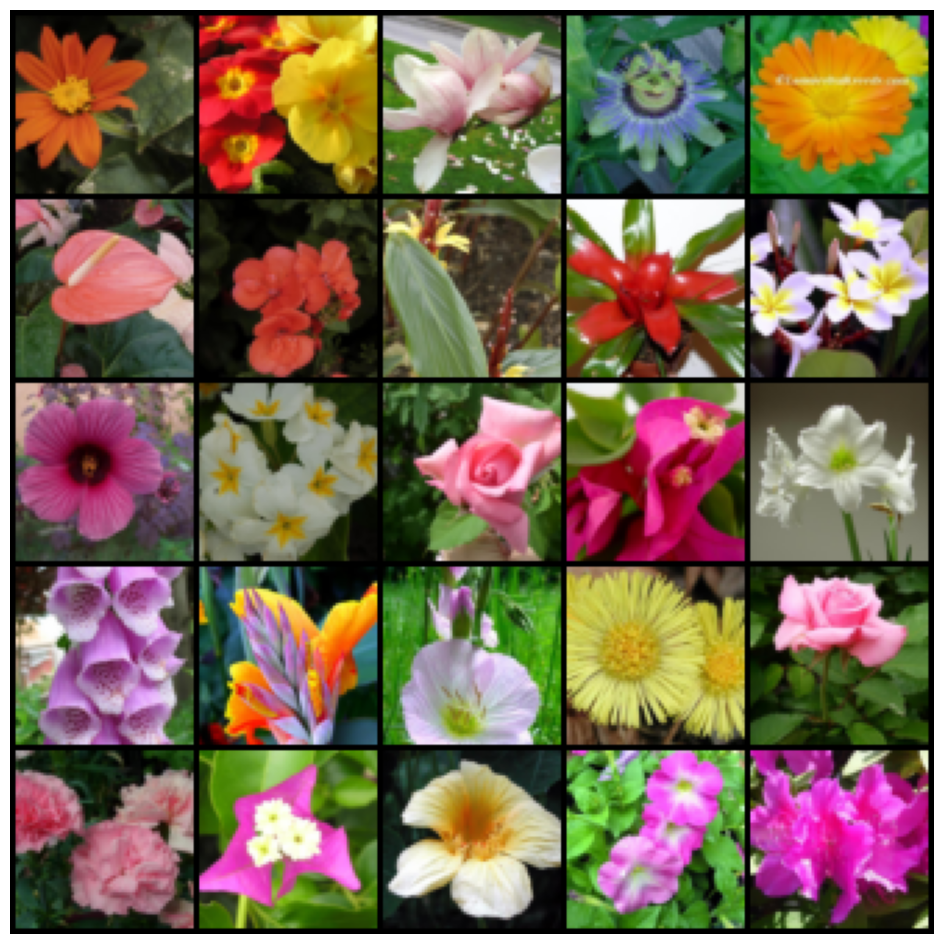

In [7]:
# Fetch a single batch of images
# Here, 'real_batch' will contain the images, and '_' ignores the second output which are the labels of the images.
real_batch, _ = next(iter(dataloader))

# Plot the images
# The 'show_tensor_images' function is called to display a grid of images from the batch.
# 'num_images=25' specifies the number of images to display from the batch.
# 'size=(3, 64, 64)' indicates the shape of the images as channels x height x width.
show_tensor_images(real_batch, num_images=25, size=(3, 64, 64), save_path='EDA_images.png')  # Adjust 'size' if your transform uses a different image size

In [9]:
# Define the Generator and Discriminator
gen = Generator(z_dim).to(device)
disc = Discriminator().to(device)

# Optimizers
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
    """
    This function initializes the weights of the models to help in the training process.
    Using normal distribution for weights and zero for biases stabilizes the learning,
    as suggested by the DCGAN paper.

    Parameters:
        m (nn.Module): A PyTorch module to initialize.
    """
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):  # Apply to convolutional layers
        nn.init.normal_(m.weight.data, 0.0, 0.02)  # Initialize weights with a mean of 0 and standard deviation of 0.02
    if isinstance(m, nn.BatchNorm2d):  # Apply to batch normalization layers
        nn.init.normal_(m.weight.data, 1.0, 0.02)  # Initialize gamma (weight) with mean 1
        nn.init.constant_(m.bias.data, 0)  # Initialize beta (bias) with 0

# Apply the weights initialization function to every submodule
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

# Print the generator model architecture
print(gen)

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [10]:
n_epochs = 200  # Total number of epochs to train
cur_step = 0  # Track the number of steps
mean_generator_loss = 0  # To accumulate generator loss over display_step steps
mean_discriminator_loss = 0  # To accumulate discriminator loss over display_step steps

for epoch in range(n_epochs):
    # Iterate over all batches of the dataset
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)  # Current batch size
        real = real.to(device)  # Move real images to the specified device

        # Train Discriminator
        disc_opt.zero_grad()  # Clear old gradients
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)  # Generate noise
        fake = gen(fake_noise)  # Generate fake images from noise
        disc_fake_pred = disc(fake.detach())  # Detach to avoid training gen on these labels
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))  # Loss for fake images being zero
        disc_real_pred = disc(real)  # Discriminator prediction on real images
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))  # Loss for real images being one
        disc_loss = (disc_fake_loss + disc_real_loss) / 2  # Average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step  # Update running total for discriminator loss
        disc_loss.backward(retain_graph=True)  # Backpropagate to compute gradients
        disc_opt.step()  # Update discriminator weights

        # Train Generator
        gen_opt.zero_grad()  # Clear old gradients
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)  # New batch of noise
        fake_2 = gen(fake_noise_2)  # Generate fake images
        disc_fake_pred = disc(fake_2)  # Discriminator prediction on new fake images
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))  # Generator wants discriminator to mistake images as real
        gen_loss.backward()  # Backpropagate to compute gradients
        gen_opt.step()  # Update generator weights
        mean_generator_loss += gen_loss.item() / display_step  # Update running total for generator loss

        # Logging and Image Display
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Epoch {epoch} Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)  # Show a batch of generated images
            show_tensor_images(real)  # Show a batch of real images
            mean_generator_loss = 0  # Reset the loss for the next display step
            mean_discriminator_loss = 0  # Reset the loss for the next display step
        cur_step += 1  # Increment the step counter

  0%|          | 0/64 [00:00<?, ?it/s]

KeyboardInterrupt: 